# Load the eval data

In [2]:
import sys
import os
import json
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

from train import Trainer

In [15]:
mat_name = 'isotropic-swift'
train_inp_name = 'pd_ms_42_200'

model_folder = Path('..','metrics',mat_name,train_inp_name)
model_dirs = list(model_folder.iterdir())

100%|██████████| 184/184 [00:05<00:00, 35.00it/s]


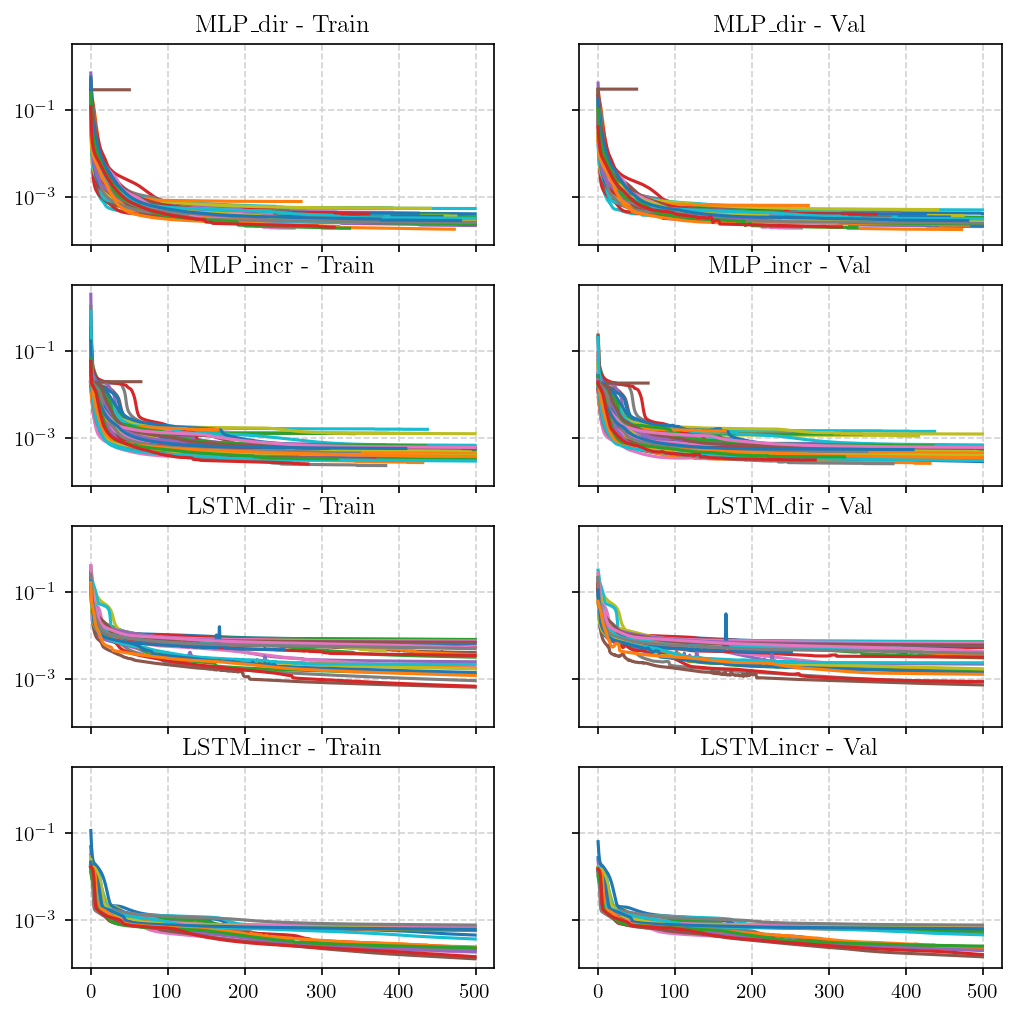

In [16]:
fig, ax = plt.subplots(4,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

for model_dir in tqdm(model_dirs):

    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')
    
    if not trainer.model.incr and trainer.model.network_name == 'MLP' : 
        ax[0,0].plot(trainer.train_losses)
        ax[0,1].plot(trainer.val_losses)
    if trainer.model.incr and trainer.model.network_name == 'MLP' : 
        ax[1,0].plot(trainer.train_losses)
        ax[1,1].plot(trainer.val_losses)
    if not trainer.model.incr and trainer.model.network_name == 'LSTM': 
        ax[2,0].plot(trainer.train_losses)
        ax[2,1].plot(trainer.val_losses)
    if trainer.model.incr and trainer.model.network_name == 'LSTM': 
        ax[3,0].plot(trainer.train_losses)
        ax[3,1].plot(trainer.val_losses)


ax[0,0].set_title('MLP_dir - Train')
ax[0,1].set_title('MLP_dir - Val')
ax[1,0].set_title('MLP_incr - Train')
ax[1,1].set_title('MLP_incr - Val')
ax[2,0].set_title('LSTM_dir - Train')
ax[2,1].set_title('LSTM_dir - Val')
ax[3,0].set_title('LSTM_incr - Train')
ax[3,1].set_title('LSTM_incr - Val')
    
for a in ax.flatten(): 
    a.set_yscale('log')
    a.grid(ls='--',color='lightgray')

plt.show()

100%|██████████| 184/184 [00:05<00:00, 33.94it/s]


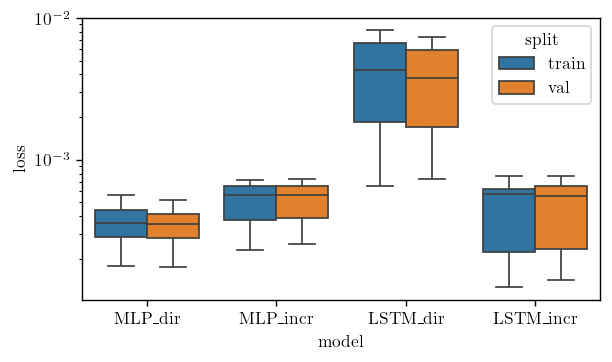

In [17]:
rows = []
for model_dir in tqdm(model_dirs):
    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')

    key = f"{trainer.model.network_name}_{trainer.model.mode}"   # e.g. MLP_dir, LSTM_incr
    
    rows.append((key, "train", trainer.train_losses[-1]))
    rows.append((key, "val", trainer.val_losses[-1]))

df = pd.DataFrame(rows, columns=["model", "split", "loss"])

df["model"] = pd.Categorical(df["model"],["MLP_dir","MLP_incr","LSTM_dir","LSTM_incr"])

plt.figure(figsize=(5,3),dpi=125)

sns.boxplot(
    data=df,
    x="model",
    y="loss",
    hue="split",
    showfliers=False,
    
)
plt.yscale("log")
plt.tight_layout()
plt.show()

In [129]:
eval_inp_names = ['amplitude','cyclic','impulse','piecewise','resolution','bl_ms_42_200','gp_42_200','rw_42_200']
cols = ['name','network','output_type','k','p','q','seed','num_params']
measure = 'MSE_rel'

In [ ]:
results_glob, results_loc = [], []

for model_dir in tqdm(model_dirs):
    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')
    
    line_glob = [
        trainer.model.name,
        trainer.model.network_name, 
        trainer.model.mode, 
        trainer.model.k,
        trainer.model.p,
        trainer.model.q,
        trainer.model.seed,
        trainer.model.num_params
    ]
    line_loc = line_glob.copy()
    
    eval_metrics_path = Path(model_folder,trainer.model.name,'eval_metrics.json',)
    test_eval_path = Path(model_folder,trainer.model.name,'test_eval.json',)
    
    with open(eval_metrics_path,'rb') as f:
        error_metrics = json.load(f)

    with open(test_eval_path,'rb') as f:
        test_eval = json.load(f)
    
    line_glob.append(test_eval['global'][measure])
    line_loc.append(test_eval['local'][measure])
    
    for eval_inp_name in eval_inp_names:

        line_glob.append(error_metrics[eval_inp_name]['global'][measure])
        line_loc.append(error_metrics[eval_inp_name]['local'][measure])

    results_glob.append(line_glob)
    results_loc.append(line_loc)


df_glob = pd.DataFrame(results_glob, columns=cols+['test']+eval_inp_names)
df_loc = pd.DataFrame(results_loc, columns=cols+['test']+eval_inp_names)

100%|██████████| 184/184 [00:04<00:00, 45.33it/s]


# Eval the modelling approach

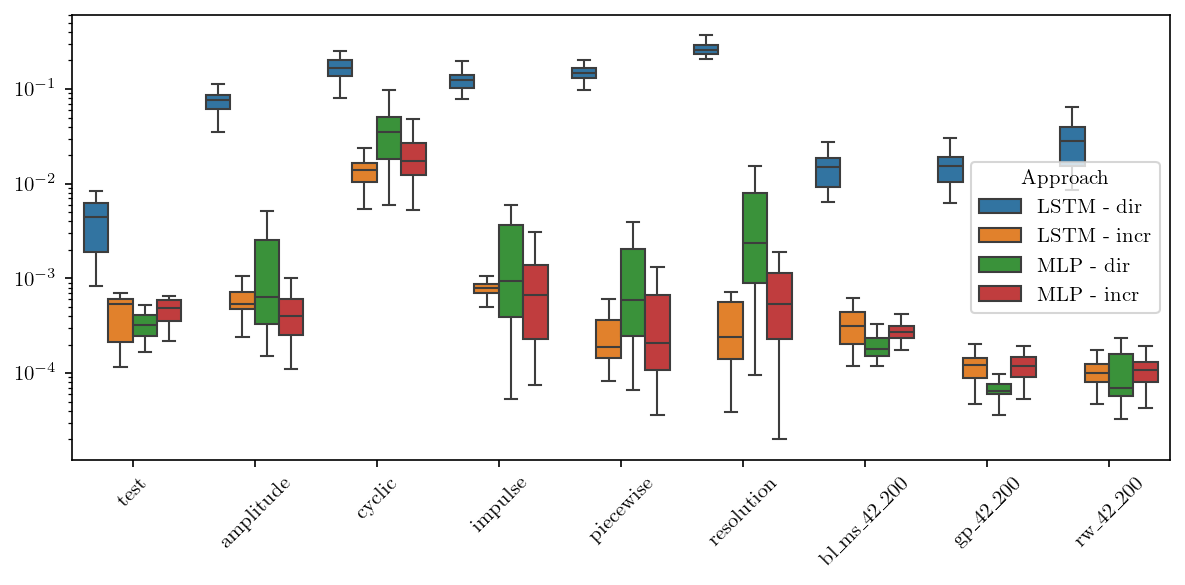

In [131]:
df_tmp = df_loc[['network','output_type'] + ['test'] + eval_inp_names]
df_tmp = df_tmp.melt(id_vars=['network','output_type'], var_name='dataset', value_name='score')
df_tmp['approach'] = df_tmp['network'] + ' - ' + df_tmp['output_type']

plt.figure(figsize=(8,4),dpi=150)
sns.boxplot(x='dataset', y='score', hue='approach', data=df_tmp, showfliers=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

Az LSTM incr és LSTM dir között miért ilyen jelentős az eltérés a lokális hibában? Elméletileg az adott méretű LSTM minden idősorra ugyanolyan jól kéne illeszkedjen, nem? Nem értem.

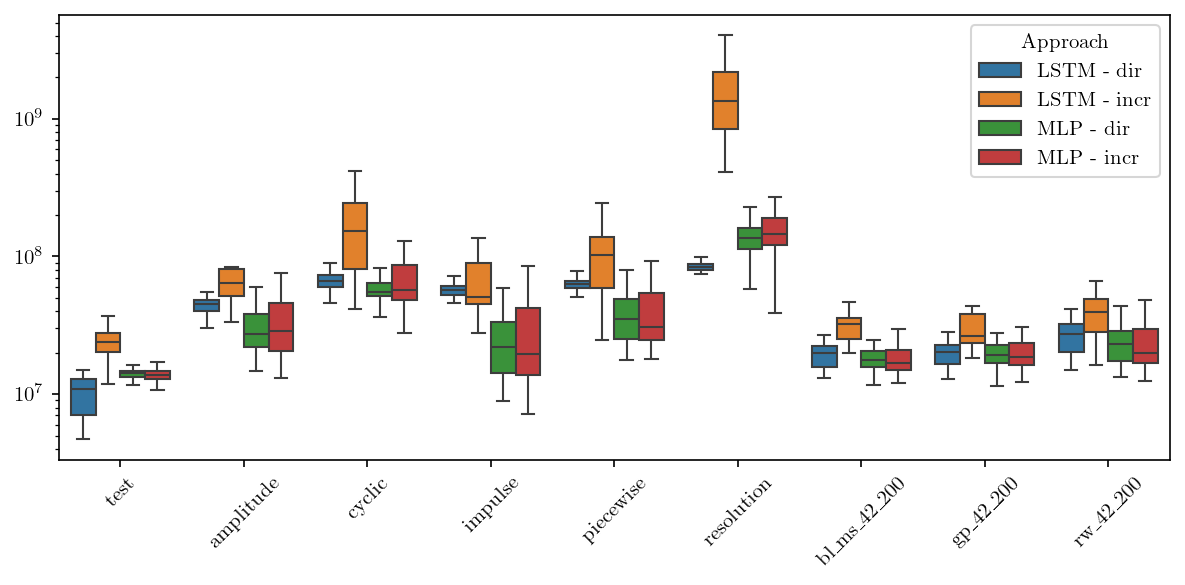

In [128]:
df_tmp = df_glob[['network','output_type'] + ['test'] + eval_inp_names]
df_tmp = df_tmp.melt(id_vars=['network','output_type'], var_name='dataset', value_name='score')
df_tmp['approach'] = df_tmp['network'] + ' - ' + df_tmp['output_type']

plt.figure(figsize=(8,4),dpi=150)
sns.boxplot(x='dataset', y='score', hue='approach', data=df_tmp, showfliers=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

Plot the top 3 surrogate models on piecewise set (based on global and local error)

In [115]:
df_glob.sort_values('test')[:10][['name','num_params','test'] + eval_inp_names]

,name,num_params,test,amplitude,cyclic,impulse,piecewise,resolution,bl_ms_42_200,gp_42_200,rw_42_200
15,LSTM-dir-2-8-2-17,1001,0.000819,0.071904,0.166835,0.121726,0.118964,0.245617,0.006372,0.008493,0.019688
23,LSTM-dir-3-8-2-38,1033,0.000894,0.080540,0.111679,0.099908,0.169443,0.277563,0.006397,0.010468,0.013028
7,LSTM-dir-0-8-2-83,937,0.001031,0.061714,0.175318,0.101609,0.105761,0.232514,0.007375,0.009147,0.015289
30,LSTM-dir-5-8-1-42,521,0.001275,0.062789,0.106857,0.090080,0.199573,0.290636,0.008591,0.006100,0.008393
31,LSTM-dir-5-8-2-56,1097,0.001341,0.038399,0.077708,0.080438,0.184356,0.265570,0.008647,0.007800,0.011498
22,LSTM-dir-3-8-1-64,457,0.001380,0.085302,0.294533,0.139369,0.170773,0.215596,0.006846,0.006533,0.009002
6,LSTM-dir-0-8-1-75,361,0.001618,0.111852,0.199970,0.151099,0.162575,0.369743,0.016702,0.017136,0.036213
28,LSTM-dir-5-5-1-83,266,0.001767,0.088873,0.160883,0.121485,0.225525,0.358832,0.008558,0.009639,0.016047
21,LSTM-dir-3-5-2-56,466,0.001889,0.101202,0.140985,0.137381,0.174407,0.327303,0.010492,0.014558,0.019779
4,LSTM-dir-0-5-1-29,166,0.002366,0.037979,0.244147,0.078376,0.163085,0.212214,0.010681,0.010888,0.015250


In [118]:
df = df_glob[['name'] + ['test'] + eval_inp_names]
df = df.drop('resolution', axis=1)

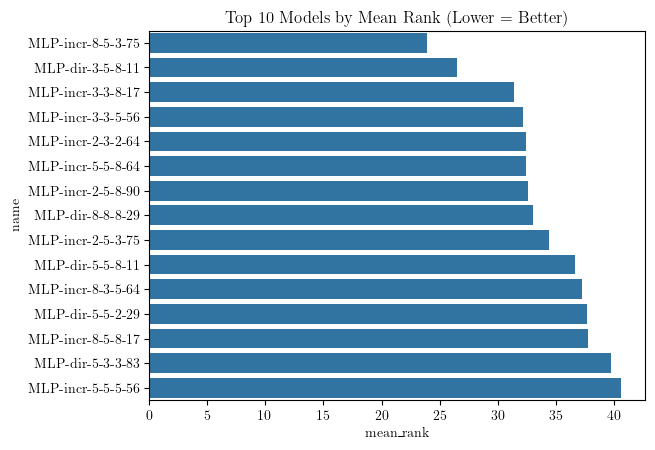

,name,test,amplitude,cyclic,impulse,piecewise,bl_ms_42_200,gp_42_200,rw_42_200
83,MLP-dir-3-5-8-11,0.007106,0.013498,0.108434,0.004127,0.020746,0.005392,0.007699,0.007607
93,MLP-dir-5-3-3-83,0.007525,0.009081,0.127903,0.008466,0.019814,0.007587,0.010788,0.006908
96,MLP-dir-5-5-2-29,0.006426,0.008291,0.107314,0.006957,0.022983,0.009190,0.011509,0.009120
99,MLP-dir-5-5-8-11,0.006447,0.009761,0.072983,0.013544,0.020588,0.008115,0.013217,0.010567
119,MLP-dir-8-8-8-29,0.004487,0.013938,0.074758,0.037691,0.051098,0.006904,0.007051,0.006624
124,MLP-incr-2-3-2-64,0.007023,0.013157,0.119400,0.007833,0.021410,0.005992,0.009110,0.005745
129,MLP-incr-2-5-3-75,0.006579,0.018026,0.057733,0.008093,0.012095,0.008466,0.010823,0.011113
131,MLP-incr-2-5-8-90,0.005791,0.013320,0.108256,0.005678,0.014844,0.009676,0.010302,0.008918
142,MLP-incr-3-3-5-56,0.007127,0.006484,0.120428,0.006468,0.022471,0.006837,0.009161,0.007317
143,MLP-incr-3-3-8-17,0.006444,0.025943,0.089766,0.004550,0.020577,0.007839,0.009778,0.007219


In [119]:
df_rank = df[df.columns[1:]].rank(axis=0, ascending=True)
df_rank['mean_rank'] = df_rank.mean(axis=1)
df_rank['name'] = df['name']

top = df_rank.sort_values('mean_rank').head(15)
sns.barplot(y='name', x='mean_rank', data=top)
plt.title("Top 10 Models by Mean Rank (Lower = Better)")
plt.show()

df[df['name'].isin(top['name'])]

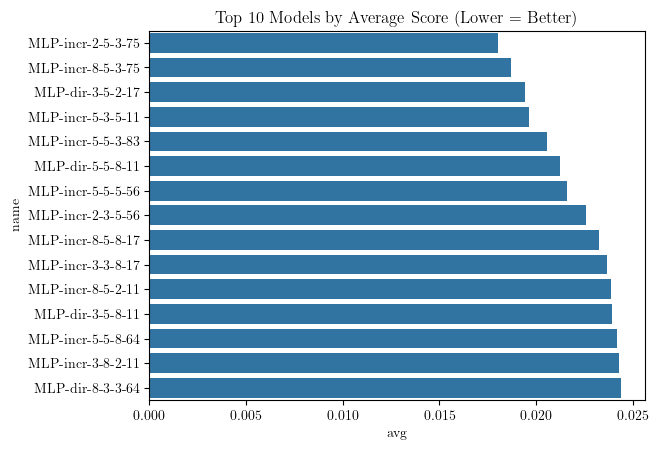

,name,test,amplitude,cyclic,impulse,piecewise,bl_ms_42_200,gp_42_200,rw_42_200,avg
129,MLP-incr-2-5-3-75,0.006579,0.018026,0.057733,0.008093,0.012095,0.008466,0.010823,0.011113,0.018050
177,MLP-incr-8-5-3-75,0.005366,0.020688,0.057353,0.003154,0.026919,0.005327,0.009165,0.008520,0.018732
80,MLP-dir-3-5-2-17,0.007079,0.017068,0.061743,0.011643,0.011776,0.008986,0.013241,0.011384,0.019406
158,MLP-incr-5-3-5-11,0.006137,0.015327,0.036792,0.007328,0.042412,0.013222,0.011990,0.010445,0.019645
161,MLP-incr-5-5-3-83,0.006680,0.012619,0.069610,0.003330,0.020121,0.014054,0.012311,0.011757,0.020543
99,MLP-dir-5-5-8-11,0.006447,0.009761,0.072983,0.013544,0.020588,0.008115,0.013217,0.010567,0.021253
162,MLP-incr-5-5-5-56,0.006890,0.022515,0.068705,0.005588,0.022398,0.007816,0.011743,0.012549,0.021616
126,MLP-incr-2-3-5-56,0.006727,0.013194,0.071015,0.003024,0.037634,0.005916,0.013481,0.013763,0.022575
179,MLP-incr-8-5-8-17,0.006167,0.024889,0.053809,0.002339,0.052116,0.007049,0.007999,0.014706,0.023272
143,MLP-incr-3-3-8-17,0.006444,0.025943,0.089766,0.004550,0.020577,0.007839,0.009778,0.007219,0.023667


In [120]:
# Compute the average score across columns (excluding 'name')
tmp = eval_inp_names.copy()
tmp.remove('resolution')
df.loc[:, 'avg'] = df[tmp].mean(axis=1)

# Select the top 10 models with highest average score
top = df.sort_values('avg', ascending=True).head(15)

# Plot
sns.barplot(y='name', x='avg', data=top)
plt.title("Top 10 Models by Average Score (Lower = Better)")
plt.show()
top